# Example Gibbs Sampler

Based on problems from Chapter 14 of Ben Lambert's "[A Student's Guide to Bayesian Statistics](https://study.sagepub.com/lambert)".

In [1]:
import random
import numpy as np
import pandas as pd
from numpy.random import beta, binomial

from gibbs_param import Parameter
from gibbs_methods import gibbs_sampler

## 14.1 - Disease Testing

The test for a particular tropical disease is known to be imperfect, not always identifying the disease if the patient has it, and sometimes yielding false 
positives (patients that do not have the disease but test positive). 

However, by using this test in a clinical trial it is hoped that we can obtain better estimates for the test sensitivity ($S$, the proportion of disease-positive individuals who test positive) and specificity ($C$, the proportion of disease-negative individuals who test negative).


To do this we can construct a table of the observed and latent data for the test outcomes (see below). In the table $a$ and $b$ are the number of observed positive and negative results, respectively. $Y_{1}$ and $Y_{2}$ are latent variables that represent the gold standard – the true number of positive
individuals out of $a$ and $b$, respectively.


|   | True +     | True - | Sum |
| ----------- | ----------- | ----------- | ----------- |
| **Test +**    | $Y_{1}$      | $ a - Y_{1}$  | $a$ |
| **Test -**  | $Y_{2}$       | $b - Y_{2}$  |  $b$  |
| **Sum**  | $Y_{1} + Y_{2}$       | $N - (Y_{1} +Y_{2})$  |  $N$  |

### Likelihood

Assuming the prevalence of the disease is $\pi$, we may write the likelihood as:

$$
L(a,b| Y_{1}, Y_{2}, \pi, S, C) = [\pi S]^{Y_{1}} \times [(1 - \pi)(1 - C)]^{a - Y_{1}} \times [\pi(1 - S)]^{Y_{2}} \times [(1 - \pi)C]^{b - Y_{2}}
$$

(The first term $[\pi S]^{Y_{1}}$ is the proportion of individuals with the disease ($\pi$) times the test specificity ($S$), giving the probability that we correctly identify one person as having the disease. This is raised to the power $Y_{1}$ since there are this many individuals with the disease in our sample.)



### Priors

Let us assume priors of the form:

* $\pi ∼ beta(\alpha_{\pi} , \beta_{\pi})$
* $S ∼ beta(\alpha_{S} , \beta_{S})$
* $C ∼ beta(\alpha_{C} , \beta_{C})$

Using these, the Gibbs sampler is of the form:

* $Y_{1}|a, \pi, S, C \sim binomial\left(a, \frac{\pi S}{\pi S + (1-\pi)(1-C)} \right)$
* $Y_{2}|b, \pi, S, C \sim binomial\left(b, \frac{\pi (1 -S)}{\pi (1-S) + (1-\pi)C} \right)$
* $\pi |a,b,Y_{1},Y_{2} \sim beta(Y_{1} + Y_{2} + \alpha_{\pi}, a+b-Y_{1}-Y_{2}+\beta_{\pi})$
* $ S|Y_{1}, Y_{2} \sim beta(Y_{1} + \alpha_{S}, Y_{2} +\beta_{S})$
* $ C|a,b,Y_{1}, Y_{2} \sim beta(b-Y_{2} + \alpha_{C},a-Y_{1} +\beta_{C})$

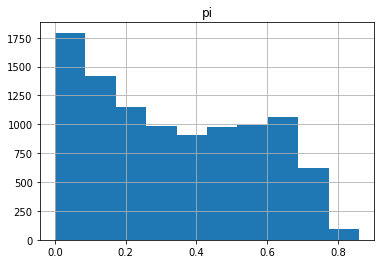

In [3]:
prior_params = {'alpha_pi': 1, 'beta_pi': 10,
                'alpha_S': 10, 'beta_S': 1,
                'alpha_C': 10, 'beta_C': 1}
priors = {'pi': beta(prior_params['alpha_pi'], prior_params['beta_pi']),
          'S': beta(prior_params['alpha_S'], prior_params['beta_S']),
          'C': beta(prior_params['alpha_C'], prior_params['beta_C'])}
sample = {'a': 80, 'b': 20}

params = {
    'Y1': Parameter(sample['a'], binomial, lambda a, pi, S, C, **kwargs: {'n':a, 'p':(pi*S)/((pi*S)+(1-pi)*(1-C))}),
    'Y2': Parameter(sample['b'], binomial, lambda b, pi, S, C, **kwargs: {'n':b, 'p':(pi*(1-S))/((pi*(1-S))+(1-pi)*C)}),
    'pi': Parameter(priors['pi'], beta, lambda a, b, Y1, Y2, **kwargs: {'a':Y1+Y2+prior_params['alpha_pi'], 'b': a+b-Y1-Y2+prior_params['beta_pi']}),
    'S': Parameter(priors['S'], beta, lambda Y1, Y2, **kwargs: {'a':Y1+prior_params['alpha_S'], 'b': Y2+prior_params['beta_S']}),
    'C': Parameter(priors['C'], beta, lambda a, b, Y1, Y2, **kwargs: {'a':b-Y2+prior_params['alpha_C'], 'b': a-Y1+prior_params['beta_C']})
}  # Defines initial starting point - give Yi as the sample values, and S,C as 90% accurate

gibbs = gibbs_sampler(10000, params = {**params, **prior_params, **sample})
gibbs.hist('pi');